# Detecting Negative Movie Reviews

The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to automatically detect negative reviews. You'll be using a dataset of IMBD movie reviews with polarity labelling to build a model for classifying positive and negative reviews. It will need to have an F1 score of at least 0.85.

## Initialization

In [1]:
import math

import numpy as np
import pandas as pd
import re

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import sklearn.metrics as metrics

from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, average_precision_score

import nltk
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords

from tqdm.auto import tqdm

from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [3]:
# this is to use progress_apply, read more at https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Load Data

In [4]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [5]:
# Preview the first few rows
df_reviews.head()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


In [6]:
# Get info about columns, types, missing values
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

In [7]:
# Show some basic statistics 
df_reviews.describe()

,start_year,is_adult,average_rating,votes,rating,pos,idx
count,47331.000000,47331.000000,47329.000000,4.732900e+04,47331.000000,47331.000000,47331.000000
mean,1989.631235,0.001732,5.998278,2.556292e+04,5.484608,0.498954,6279.697999
std,19.600364,0.041587,1.494289,8.367004e+04,3.473109,0.500004,3605.702545
min,1894.000000,0.000000,1.400000,9.000000e+00,1.000000,0.000000,0.000000
25%,1982.000000,0.000000,5.100000,8.270000e+02,2.000000,0.000000,3162.000000
50%,1998.000000,0.000000,6.300000,3.197000e+03,4.000000,0.000000,6299.000000
75%,2004.000000,0.000000,7.100000,1.397400e+04,9.000000,1.000000,9412.000000
max,2010.000000,1.000000,9.700000,1.739448e+06,10.000000,1.000000,12499.000000


In [8]:
# Check for missing values in each column
df_reviews.isnull().sum()

tconst             0
title_type         0
primary_title      0
original_title     0
start_year         0
end_year           0
runtime_minutes    0
is_adult           0
genres             0
average_rating     2
votes              2
review             0
rating             0
sp                 0
pos                0
ds_part            0
idx                0
dtype: int64

In [9]:
# Clean the review text
def clean_text(text):
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    text = text.lower()
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df_reviews['review_clean'] = df_reviews['review'].apply(clean_text)

# Preprocessing Summary

## Data Loading
- The dataset was loaded from a TSV file, including all relevant columns (e.g., `review`, `pos`, `ds_part`, `tconst`, `start_year`, `rating`, etc.).
- Data types were specified where needed to ensure proper handling of numerical columns.

## Data Cleaning
- Checked for missing values.
- Standardized column types (e.g., ensured `start_year` and `rating` were integers).
- Cleaned the review text (lowercased, removed punctuation/special characters, etc.) and stored in a new column (`review_clean`).

---

**Conclusion:**  
Preprocessing steps ensured that the dataset is clean, well-structured, and ready for exploratory analysis and subsequent modeling.

## EDA

Let's check the number of movies and reviews over years.

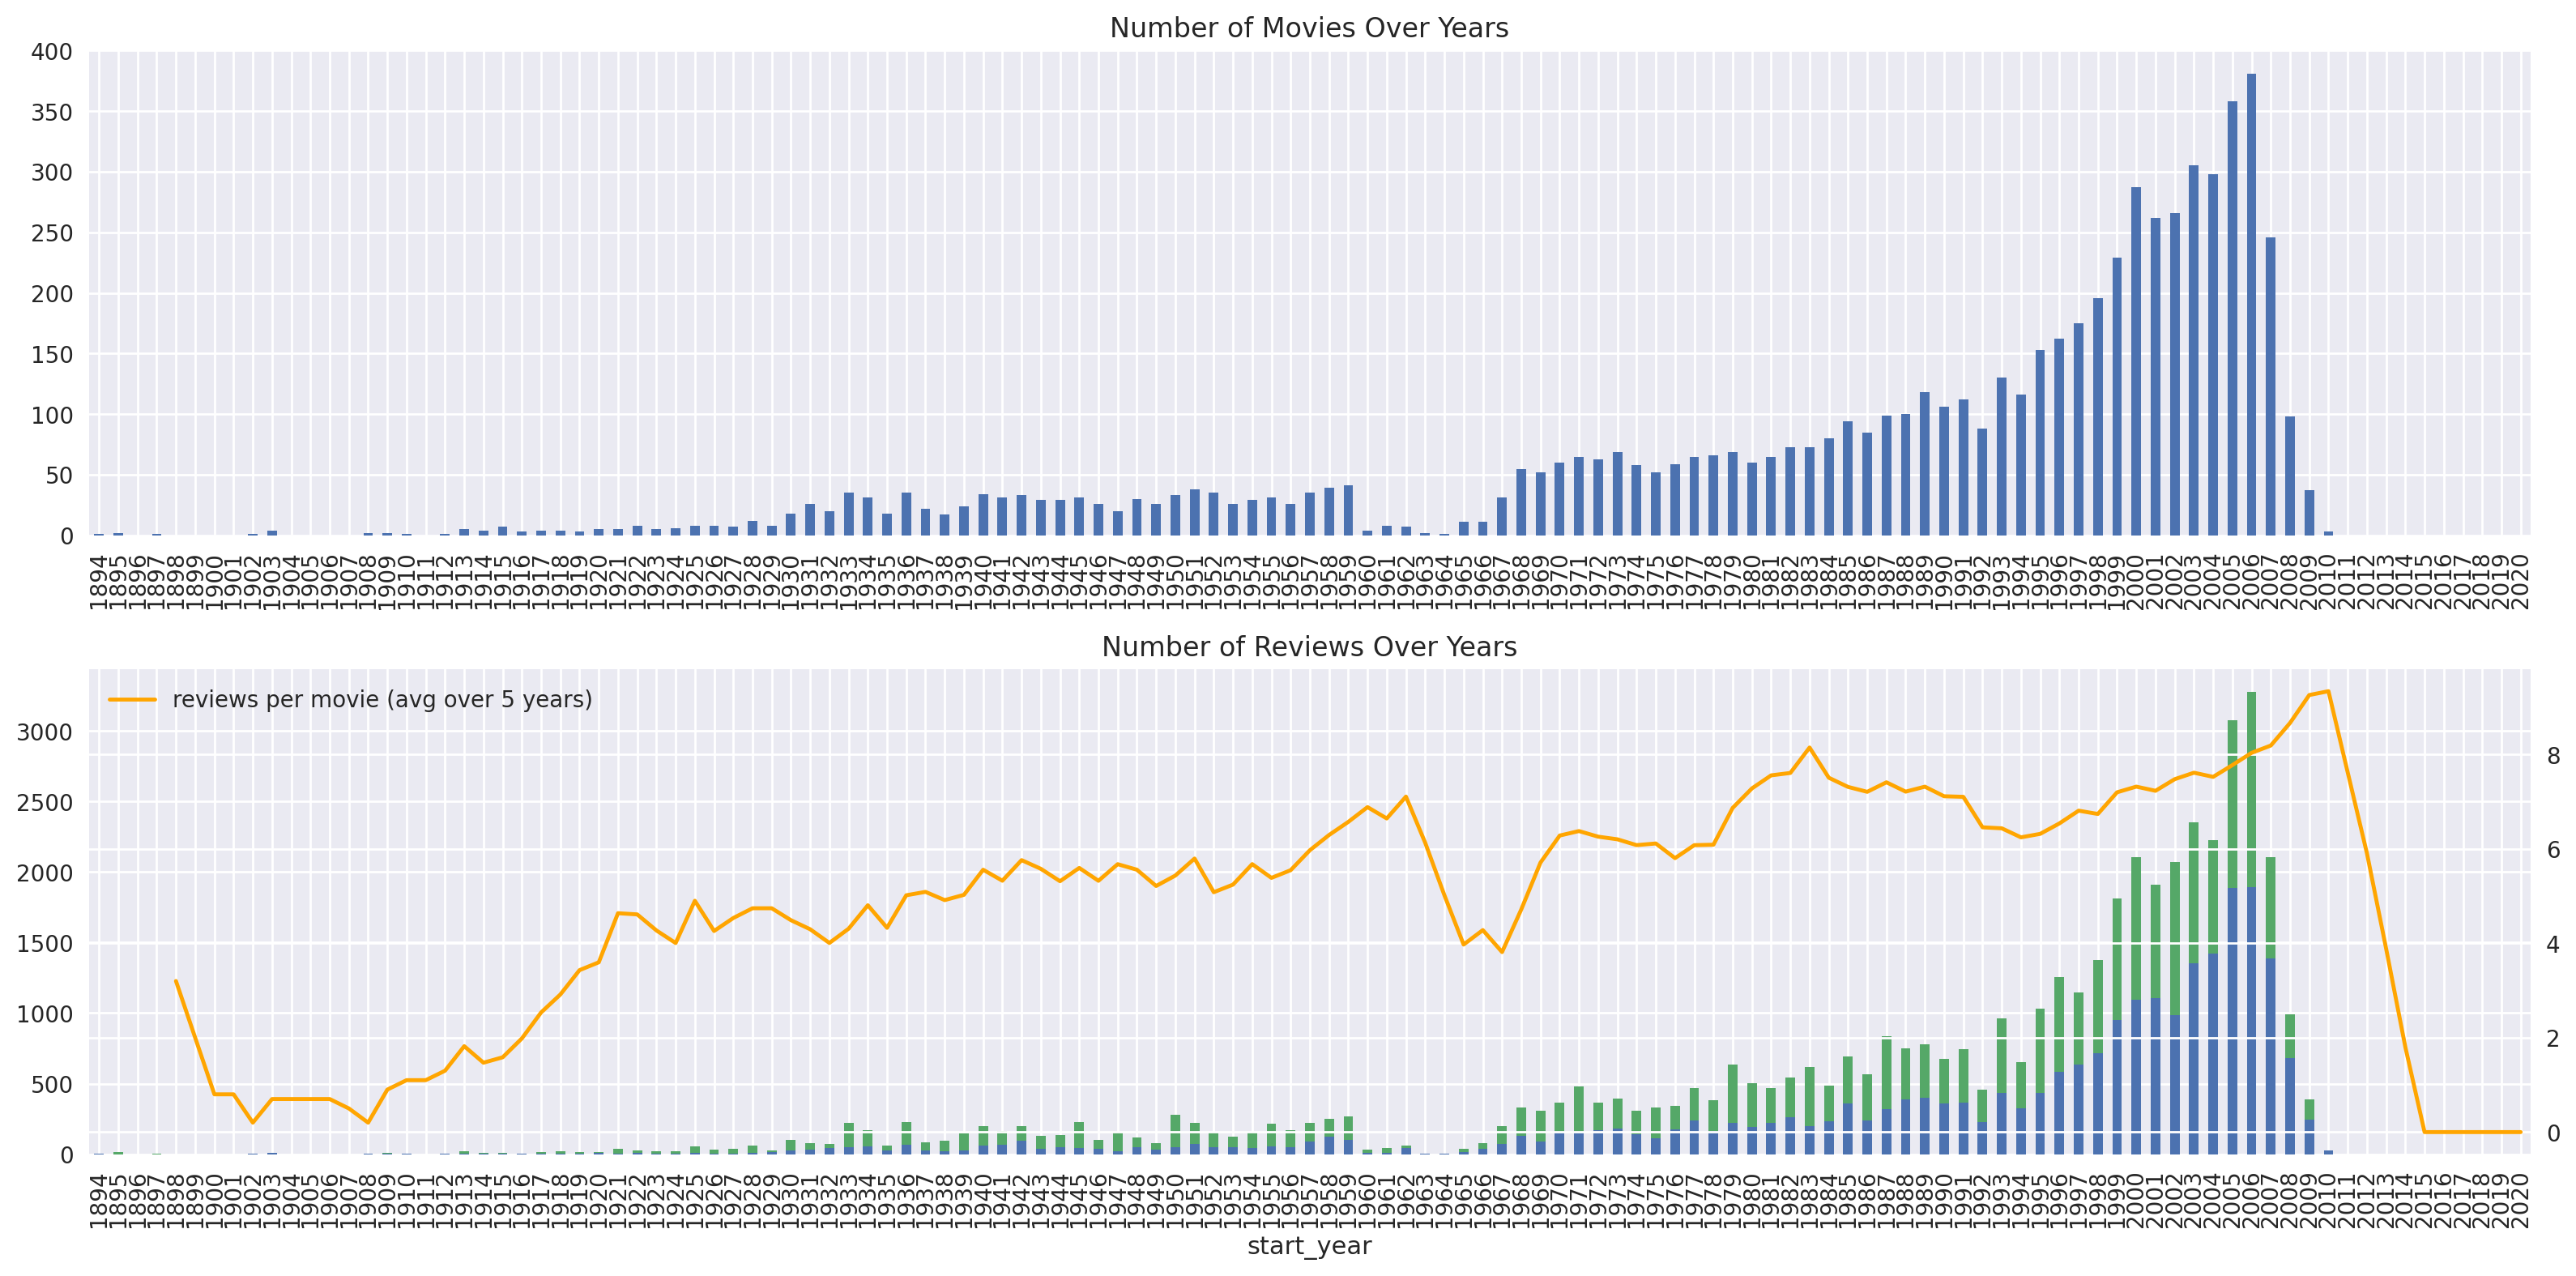

In [10]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()

Let's check the distribution of number of reviews per movie with the exact counting and KDE (just to learn how it may differ from the exact counting)

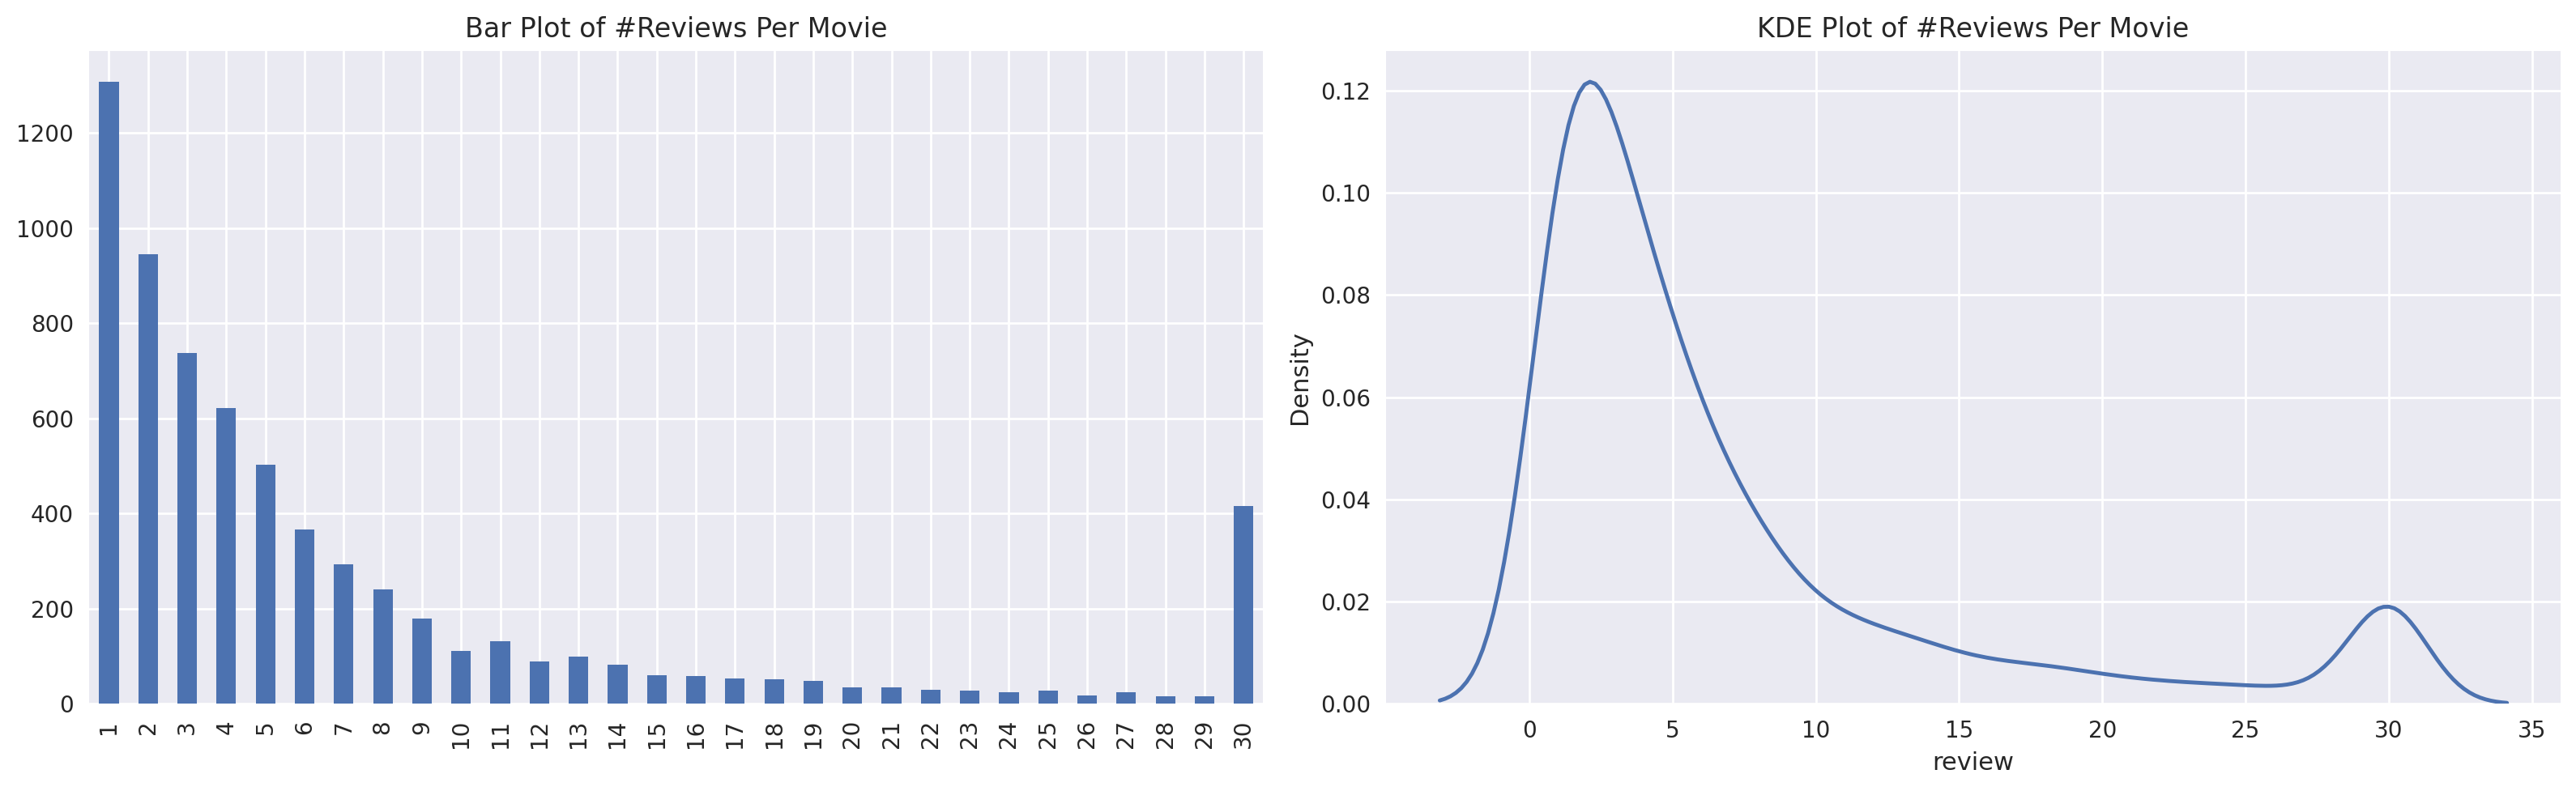

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

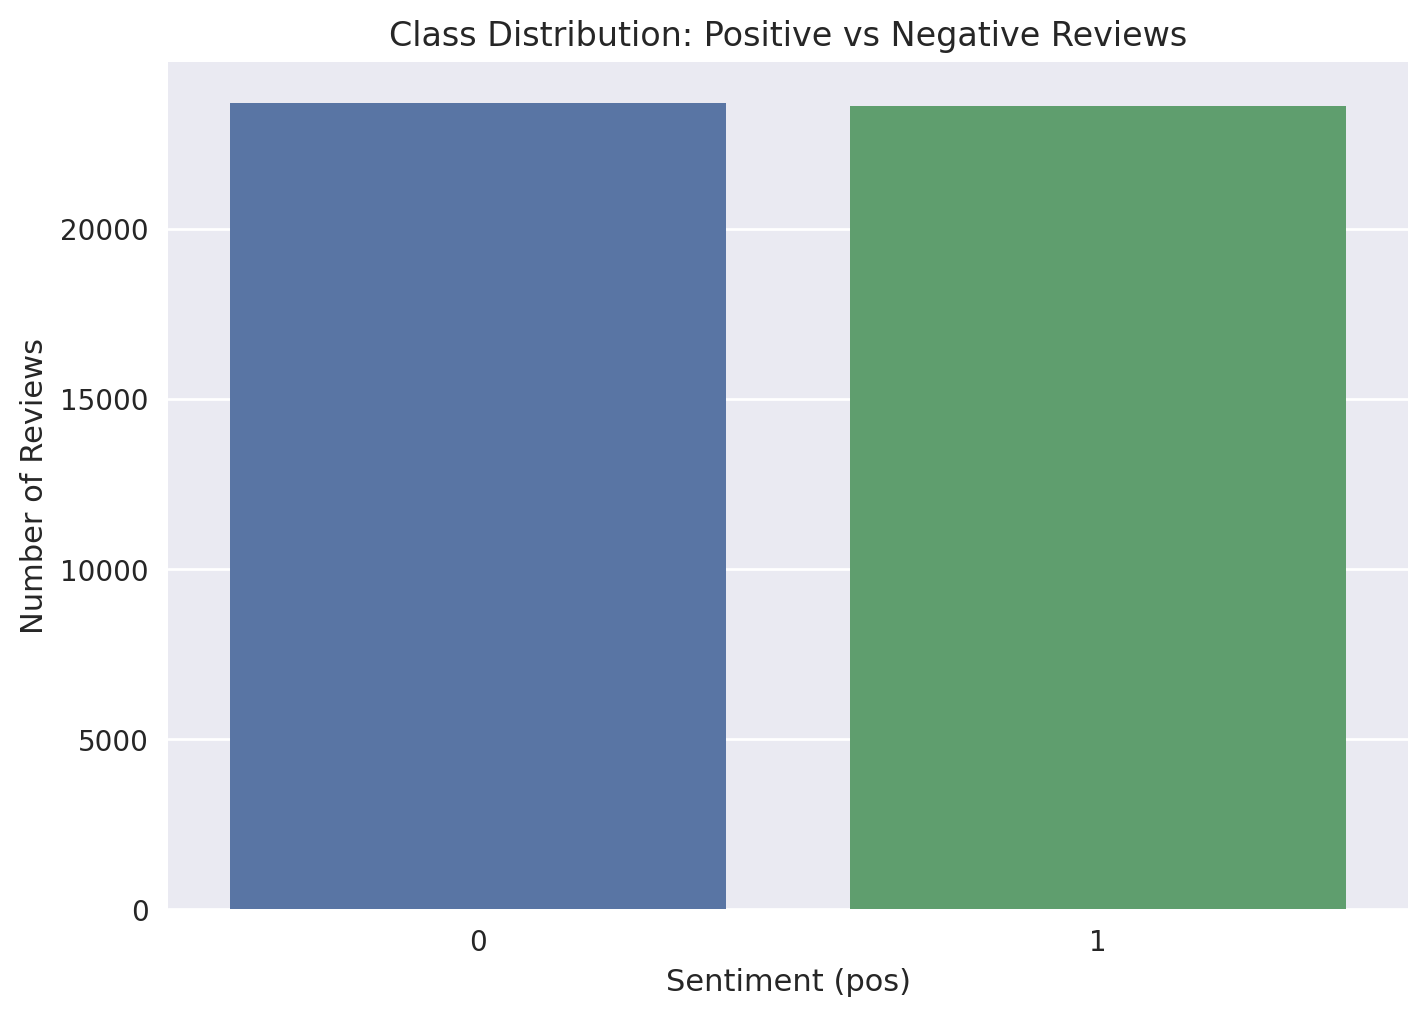

In [12]:
# visualize the class balance of your target column
sns.countplot(x='pos', data=df_reviews)
plt.title('Class Distribution: Positive vs Negative Reviews')
plt.xlabel('Sentiment (pos)')
plt.ylabel('Number of Reviews')
plt.show()

In [13]:
df_reviews['pos'].value_counts()

0    23715
1    23616
Name: pos, dtype: int64

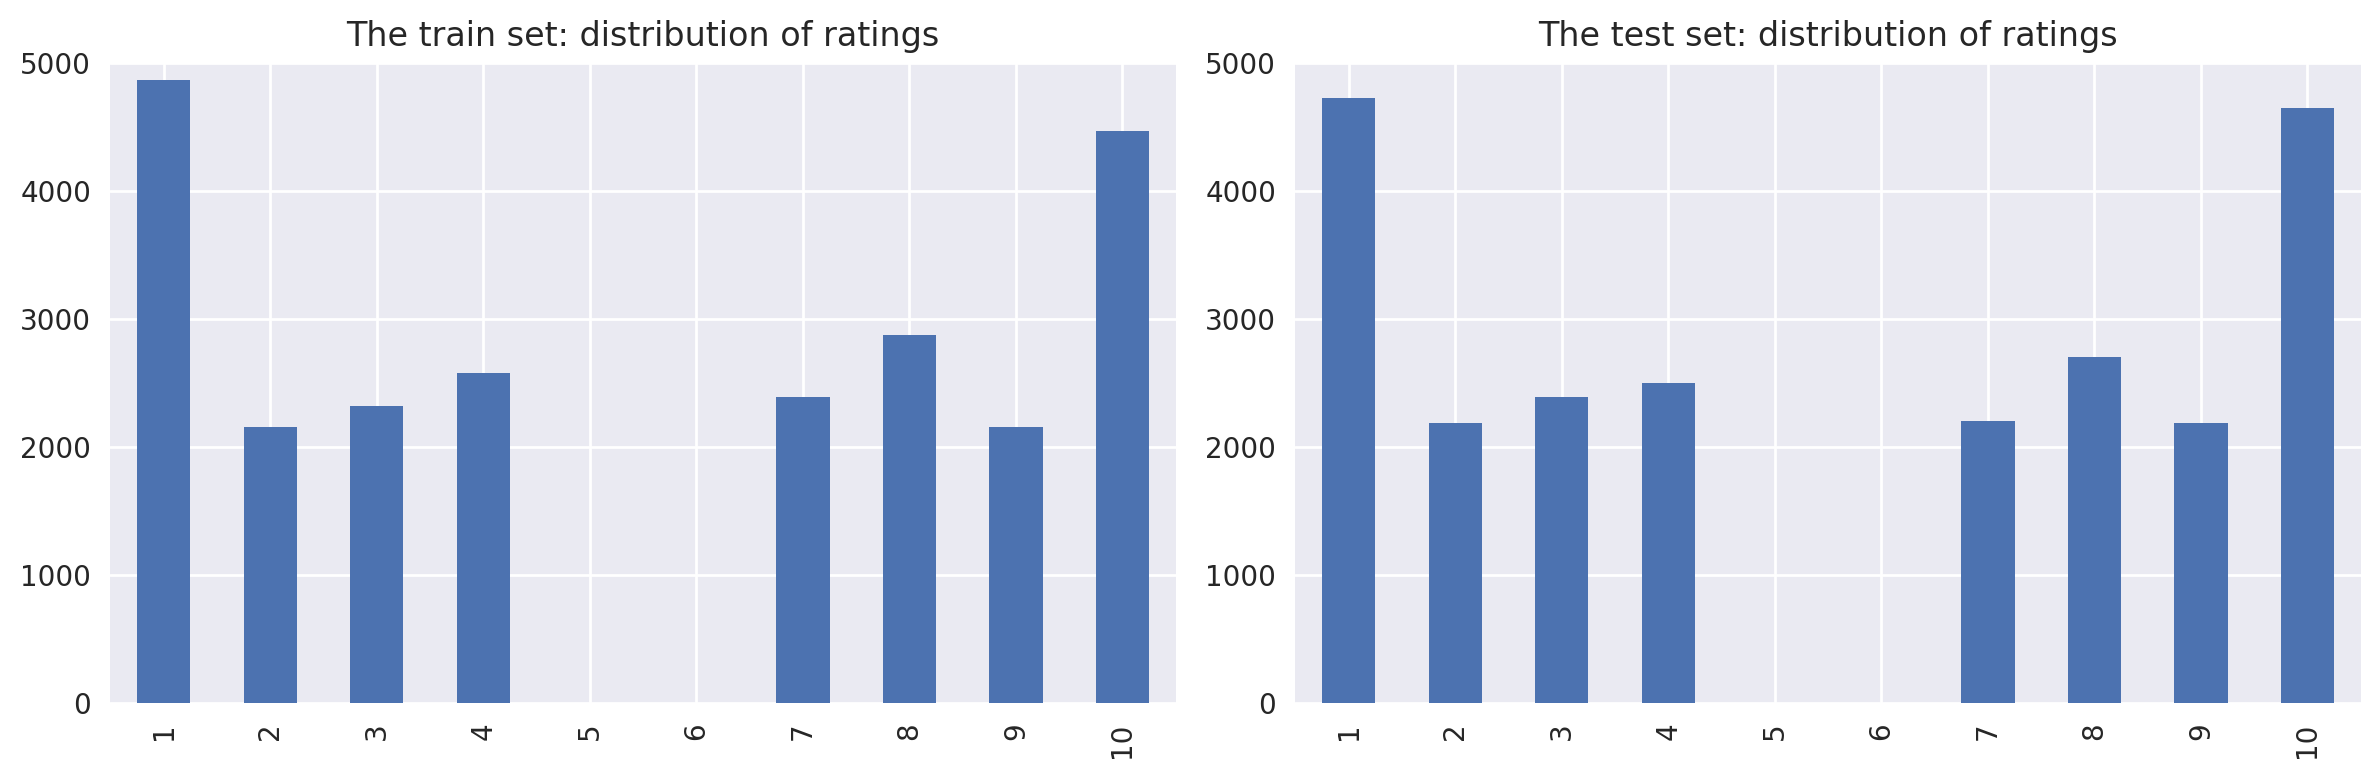

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

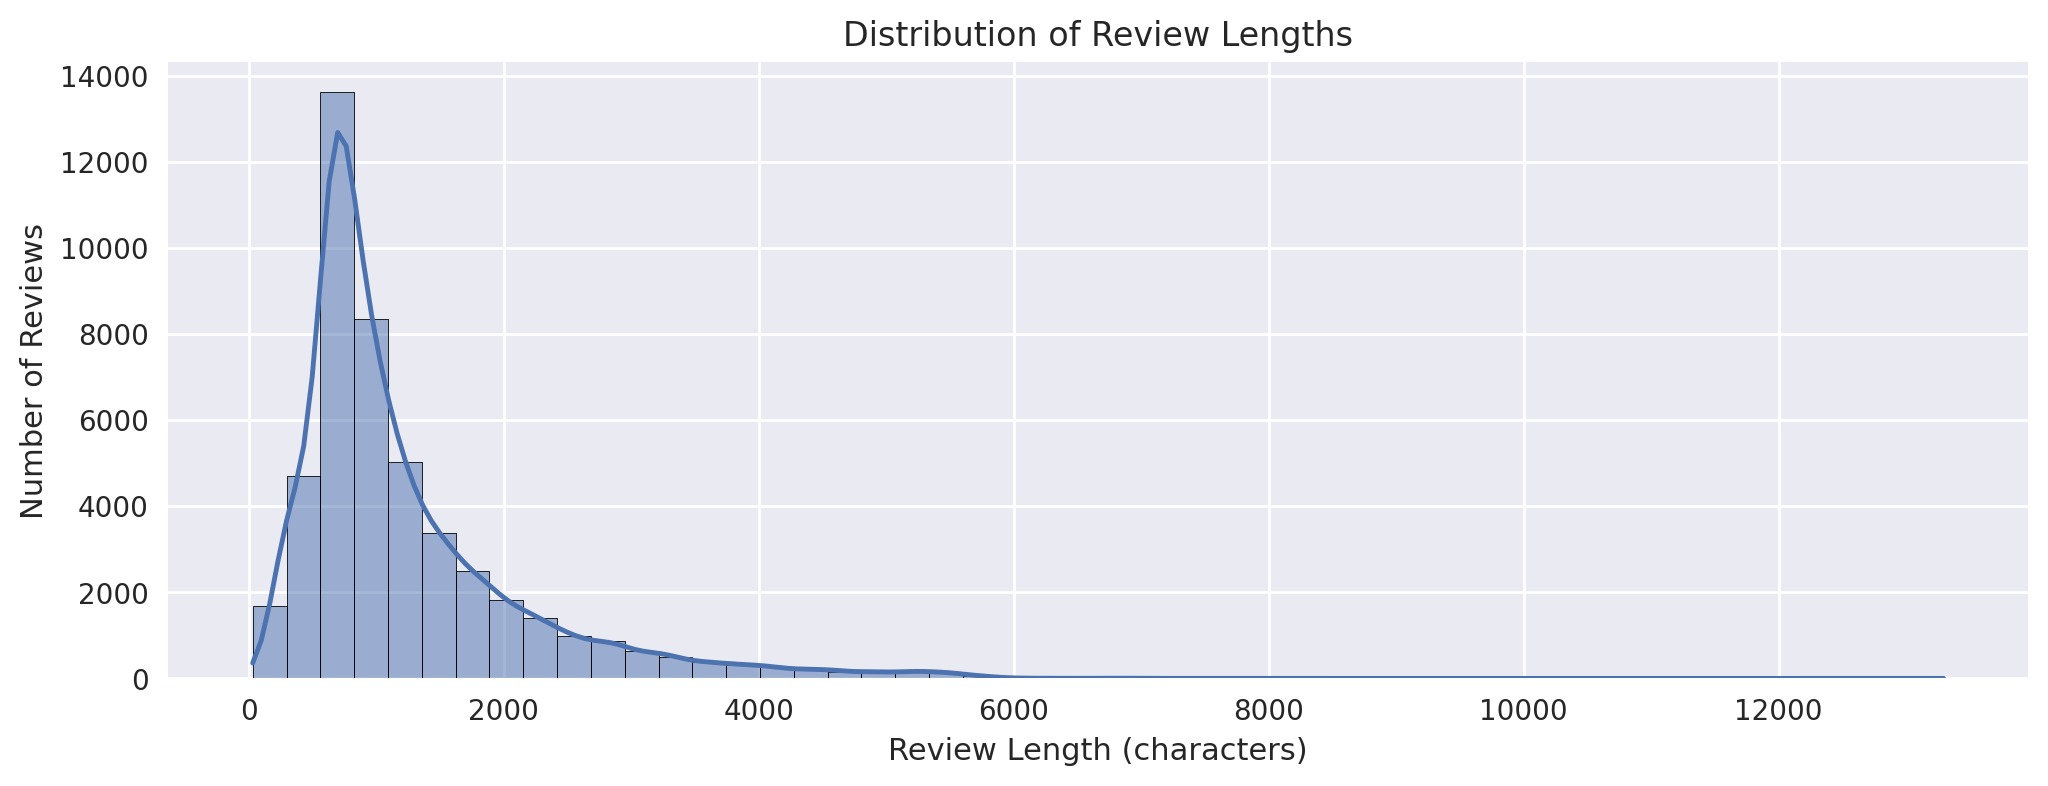

In [15]:
# Add a column for review length
df_reviews['review_length'] = df_reviews['review_clean'].apply(len)

# Plot distribution of review lengths
plt.figure(figsize=(12, 4))
sns.histplot(df_reviews['review_length'], bins=50, kde=True)
plt.title('Distribution of Review Lengths')
plt.xlabel('Review Length (characters)')
plt.ylabel('Number of Reviews')
plt.show()

Distribution of negative and positive reviews over the years for two parts of the dataset

/.venv/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/.venv/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/.venv/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/.venv/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


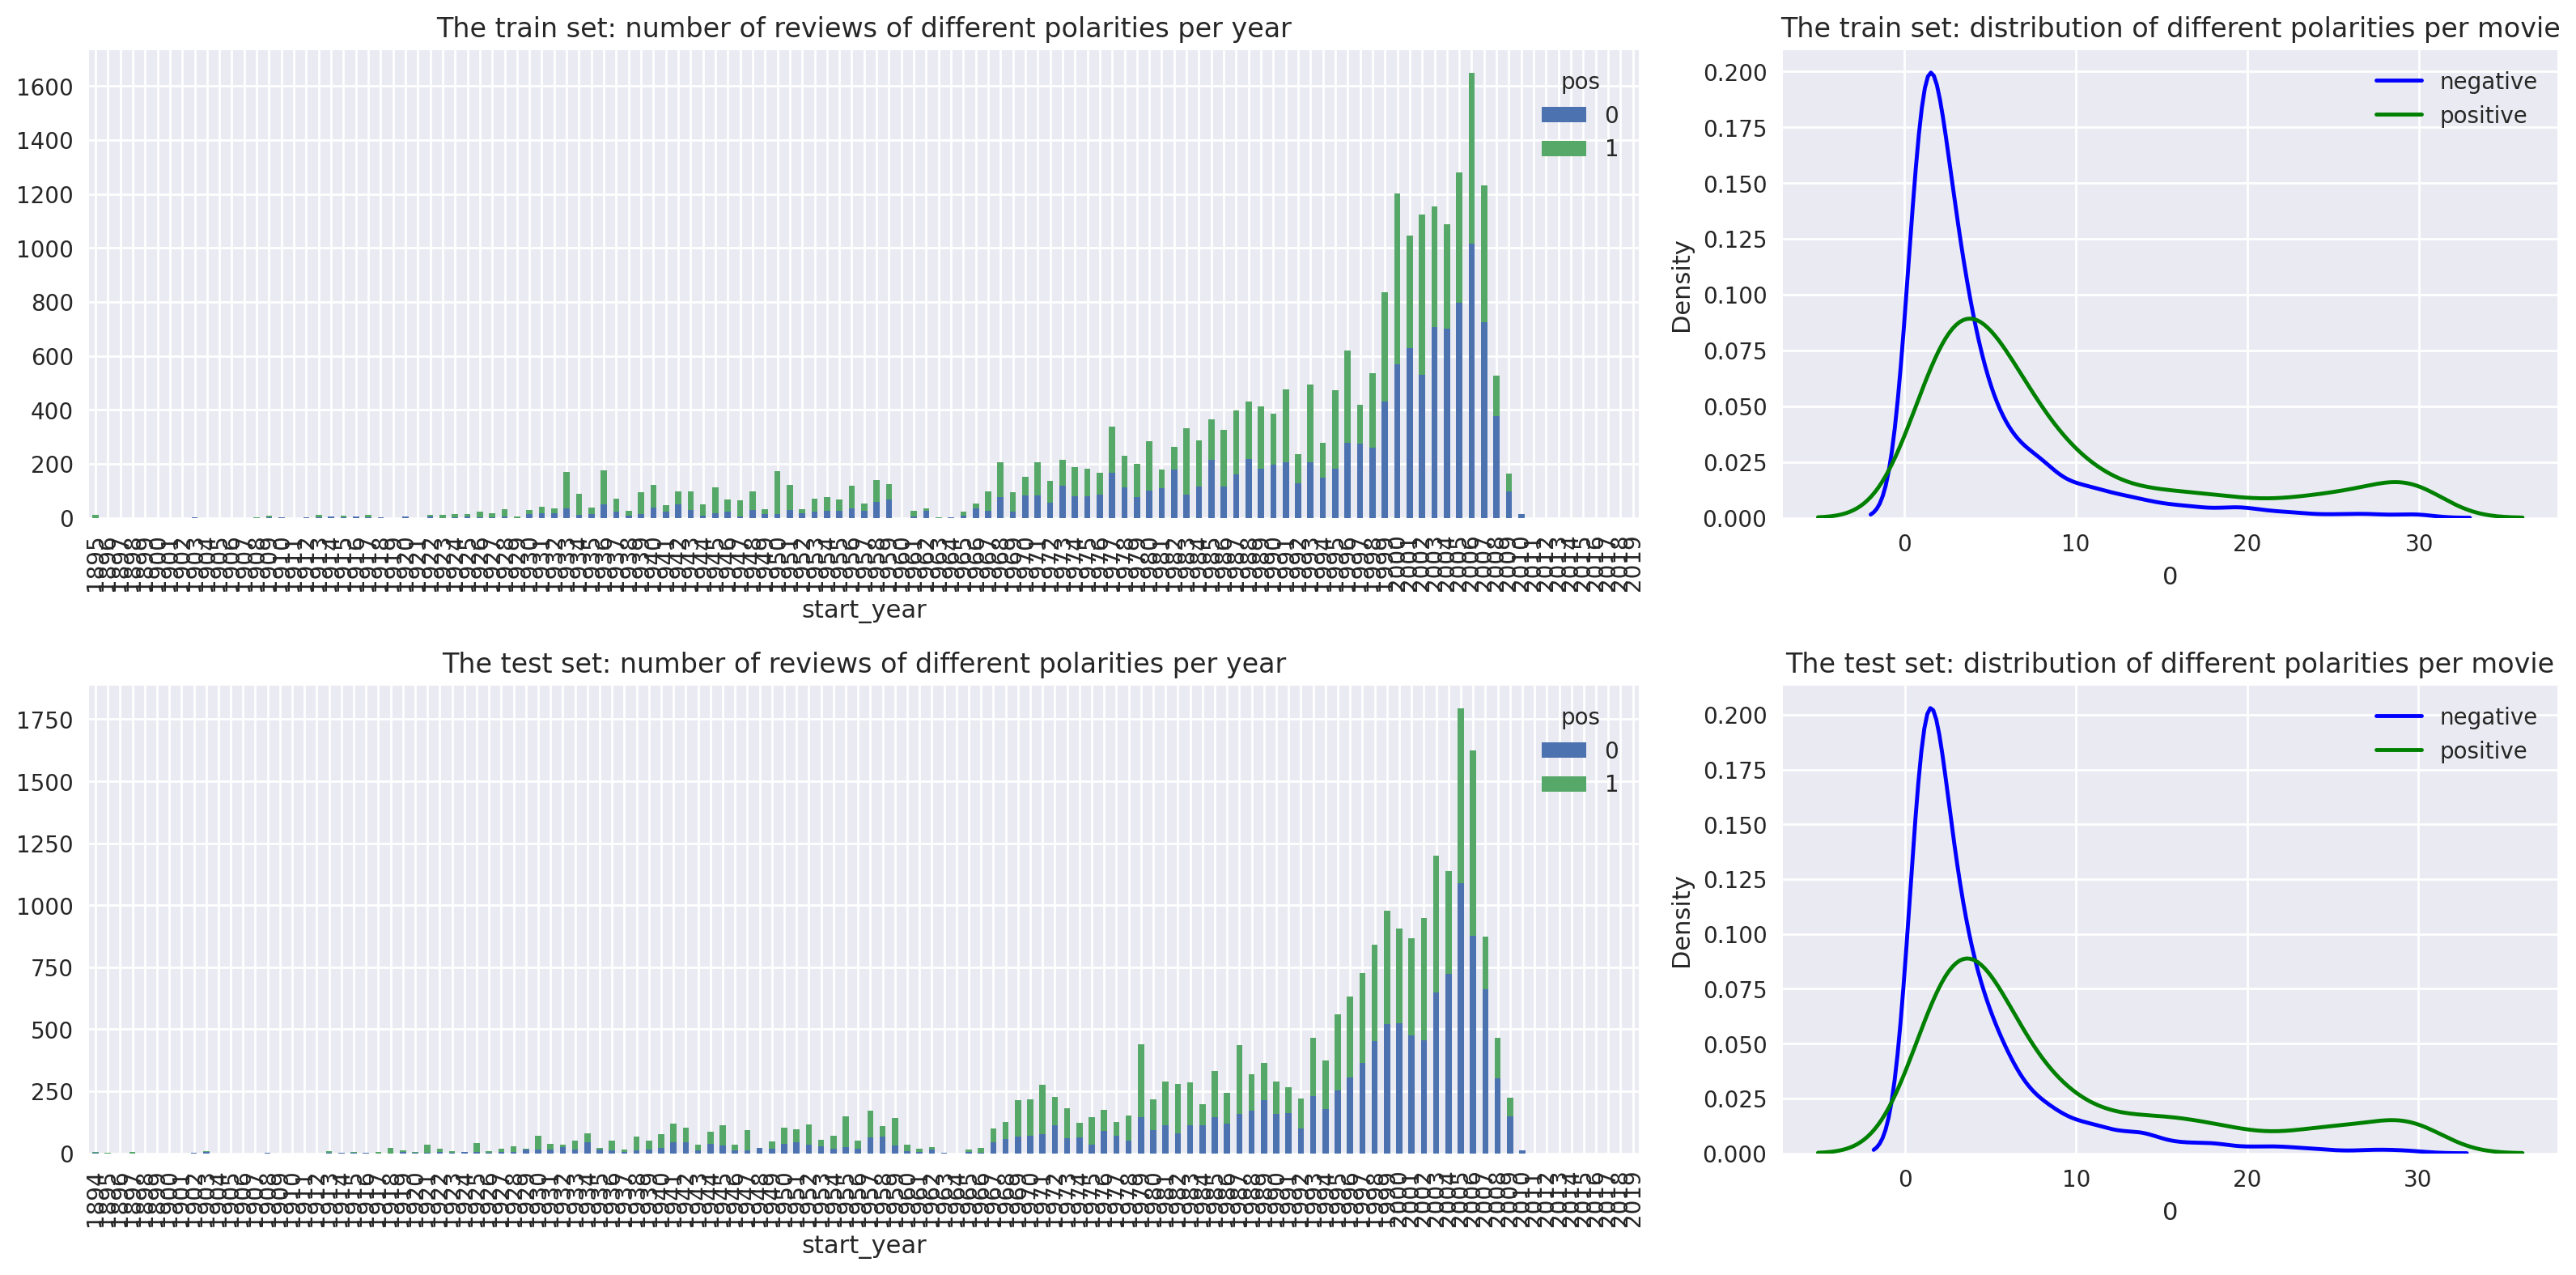

In [16]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

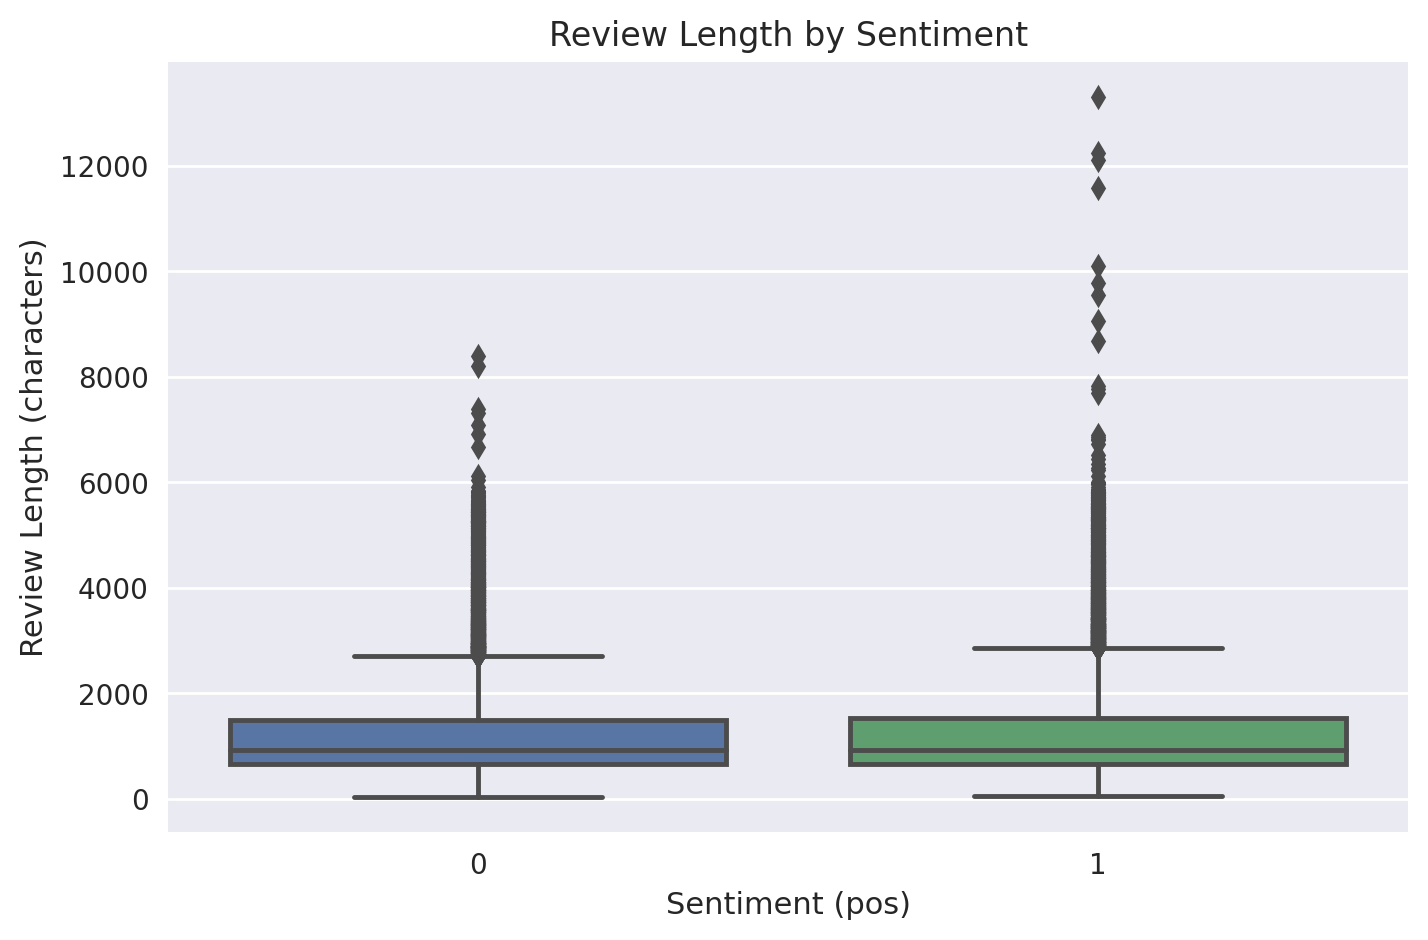

In [17]:
# Boxplot of review length by sentiment: Shows if positive and negative reviews tend to be longer or shorter.
plt.figure(figsize=(8, 5))
sns.boxplot(x='pos', y='review_length', data=df_reviews)
plt.title('Review Length by Sentiment')
plt.xlabel('Sentiment (pos)')
plt.ylabel('Review Length (characters)')
plt.show()

# Exploratory Data Analysis (EDA) Summary

## 1. Movies and Reviews Over Time
- The number of movies released each year increased steadily, peaking in the early 2000s.
- The number of reviews per year also rose, particularly for more recent films.
- The average number of reviews per movie (rolling 5-year average) shows periods of higher audience engagement.

## 2. Distribution of Reviews Per Movie
- Most movies receive only a handful of reviews, with a small number getting many reviews.
- Both bar plots and KDE plots confirm this right-skewed distribution.

## 3. Sentiment Class Balance
- The dataset is well balanced: there are roughly equal numbers of positive and negative reviews.
- This balance means that no special techniques are needed to address class imbalance during modeling.

## 4. Ratings Distribution in Train and Test Sets
- Both sets show similar rating distributions, with ratings of 1 and 10 being most common.
- This similarity ensures that the train and test splits are representative of the whole dataset.

## 5. Review Length Analysis
- Most reviews are short (under 1000 characters), but there are some very long outliers.
- The boxplot of review length by sentiment shows that positive reviews tend to be slightly longer than negative ones, though both have similar distributions.

## 6. Sentiment Distribution Over Time and Per Movie
- The number of positive and negative reviews per year follows similar trends in both train and test sets.
- KDE plots reveal that negative reviews are more concentrated at shorter lengths, while positive reviews are more spread out.

---

**Conclusion:**  
The dataset is balanced by sentiment, has a typical right-skewed text length distribution, and train/test splits are representative. These insights support robust modeling and help inform preprocessing steps for sentiment analysis.

## Evaluation Procedure

Composing an evaluation routine which can be used for all models in this project

In [18]:
def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalization

We assume all models below accepts texts in lowercase and without any digits, punctuations marks etc.

In [19]:
df_reviews['review_norm'] = df_reviews['review_clean'].str.lower() \
    .apply(lambda x: re.sub(r'[\d]', '', x)) \
    .apply(lambda x: re.sub(r'[^\w\s]', '', x))

## Train / Test Split

Luckily, the whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.

In [20]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 20)
(23535, 20)


# Preprocessing for Modeling Summary

## Text Normalization
- All review texts were converted to lowercase.
- Digits and punctuation marks were removed from the reviews.
- The normalized text was stored in a new column, `review_norm`, ready for feature extraction.

## Train/Test Split
- The dataset was split into training and test sets using the `ds_part` column.
- `df_reviews_train` and `df_reviews_test` were created, each containing all necessary columns for modeling.
- The target variable (`pos`, indicating sentiment) was separated into `train_target` and `test_target`.
- The resulting splits are balanced in size, with approximately 23,800 samples in train and 23,500 in test.

---

**Conclusion:**  
All review texts have been cleaned and normalized, and the data has been split into train and test sets. The dataset is now ready for feature engineering and model training.

## Working with models

### Model 0 - Constant

In [21]:
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(df_reviews_train['review_norm'], train_target) 

DummyClassifier(strategy='most_frequent')

In [22]:
vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(df_reviews_train['review_norm'])
X_test_vec = vectorizer.transform(df_reviews_test['review_norm'])
dummy.fit(X_train_vec, train_target)

DummyClassifier(strategy='most_frequent')

          train  test
Accuracy    0.5   0.5
F1          0.0   0.0
APS         0.5   0.5
ROC AUC     0.5   0.5


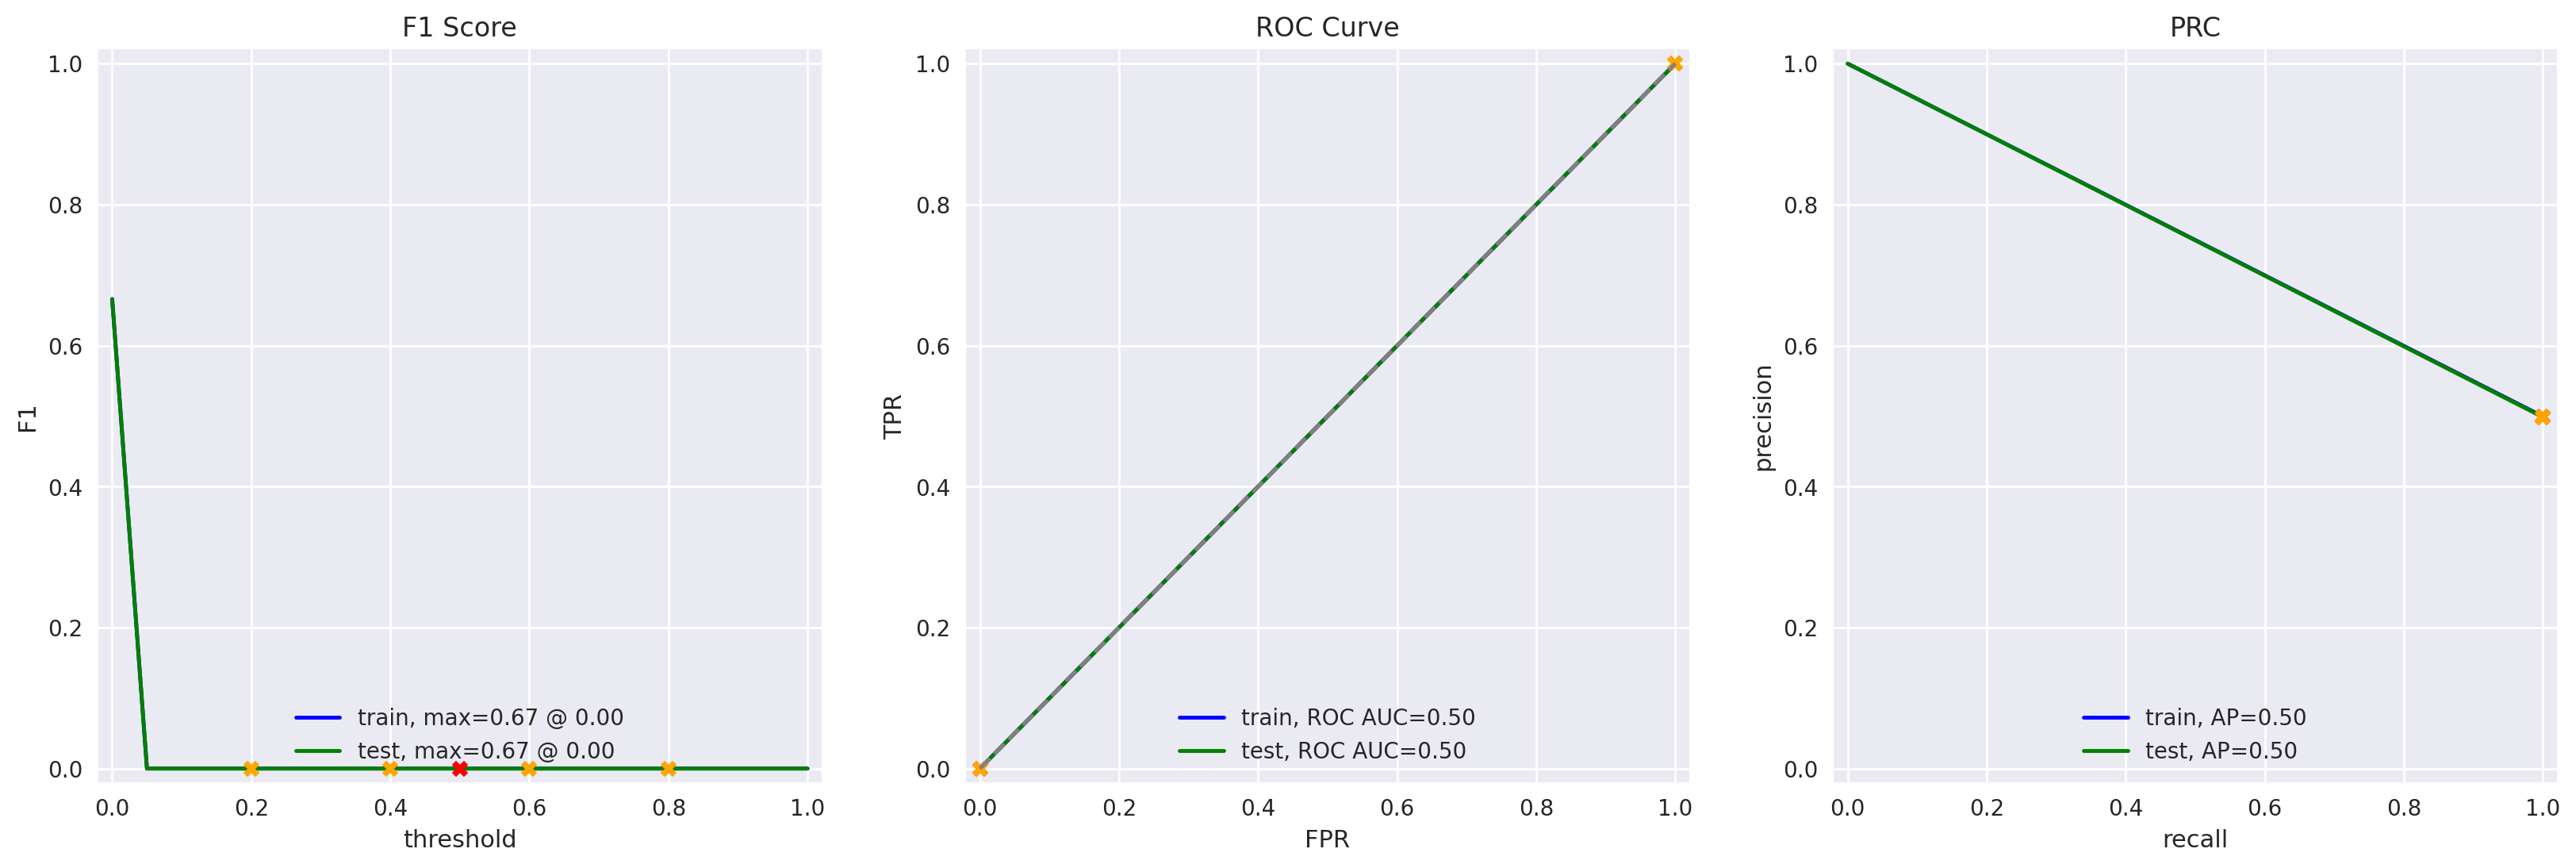

In [23]:
evaluate_model(dummy, X_train_vec, train_target, X_test_vec, test_target)

### Model 1 - NLTK, TF-IDF and LR

TF-IDF

In [24]:
vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'))
train_features_1 = vectorizer.fit_transform(df_reviews_train['review_norm'])
test_features_1 = vectorizer.transform(df_reviews_test['review_norm'])

In [25]:
model_1 = LogisticRegression(max_iter=1000)
model_1.fit(train_features_1, train_target)

LogisticRegression(max_iter=1000)

          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


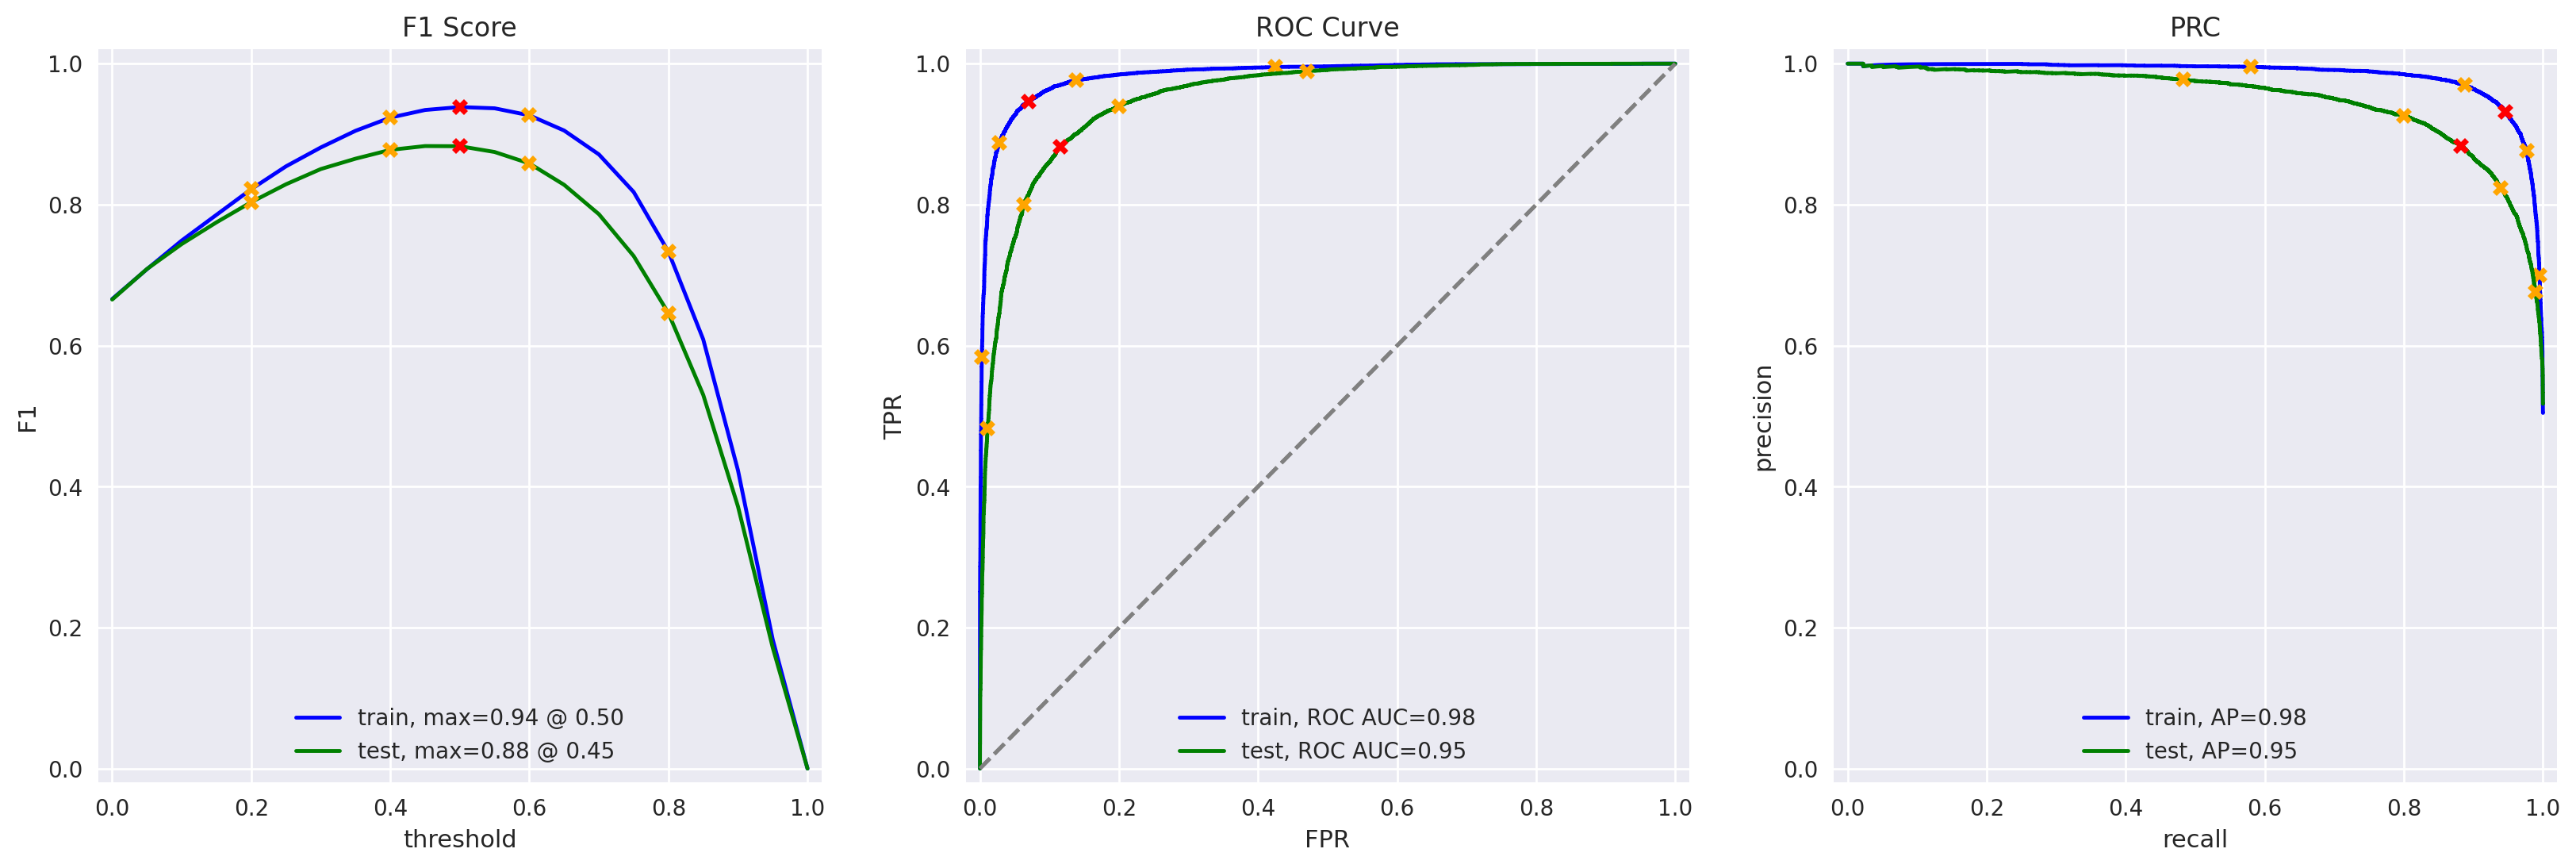

In [26]:
evaluate_model(model_1, train_features_1, train_target, test_features_1, test_target)
plt.show()

### Model 3 - spaCy, TF-IDF and LR

In [27]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [28]:
def text_preprocessing_3(text):
    
    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc]
    
    return ' '.join(tokens)

In [29]:
# (train + test separately)
def process_spacy_reviews(reviews, batch_size=50):  # Smaller batch size
    processed_reviews = []
    
    for start in range(0, len(reviews), batch_size):
        end = start + batch_size
        batch = reviews.iloc[start:end]
        
        # Process batch with spaCy
        docs = nlp.pipe(batch, batch_size=20)
        batch_lemmas = [' '.join([token.lemma_ for token in doc]) for doc in docs]
        processed_reviews.extend(batch_lemmas)
    
    return processed_reviews

# Process train and test separately 
print("Processing training reviews...")
train_spacy = process_spacy_reviews(df_reviews_train['review_norm'])
df_reviews_train['review_spacy'] = train_spacy

print("Processing test reviews...")  
test_spacy = process_spacy_reviews(df_reviews_test['review_norm'])
df_reviews_test['review_spacy'] = test_spacy

Processing training reviews...
Processing test reviews...


In [30]:
# TF-IDF vectorization on lemmatized text
vectorizer = TfidfVectorizer()
train_features_3 = vectorizer.fit_transform(df_reviews_train['review_spacy'])
test_features_3 = vectorizer.transform(df_reviews_test['review_spacy'])

# Train Logistic Regression
model_3 = LogisticRegression(max_iter=1000)
model_3.fit(train_features_3, train_target)

LogisticRegression(max_iter=1000)

          train  test
Accuracy   0.93  0.88
F1         0.93  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


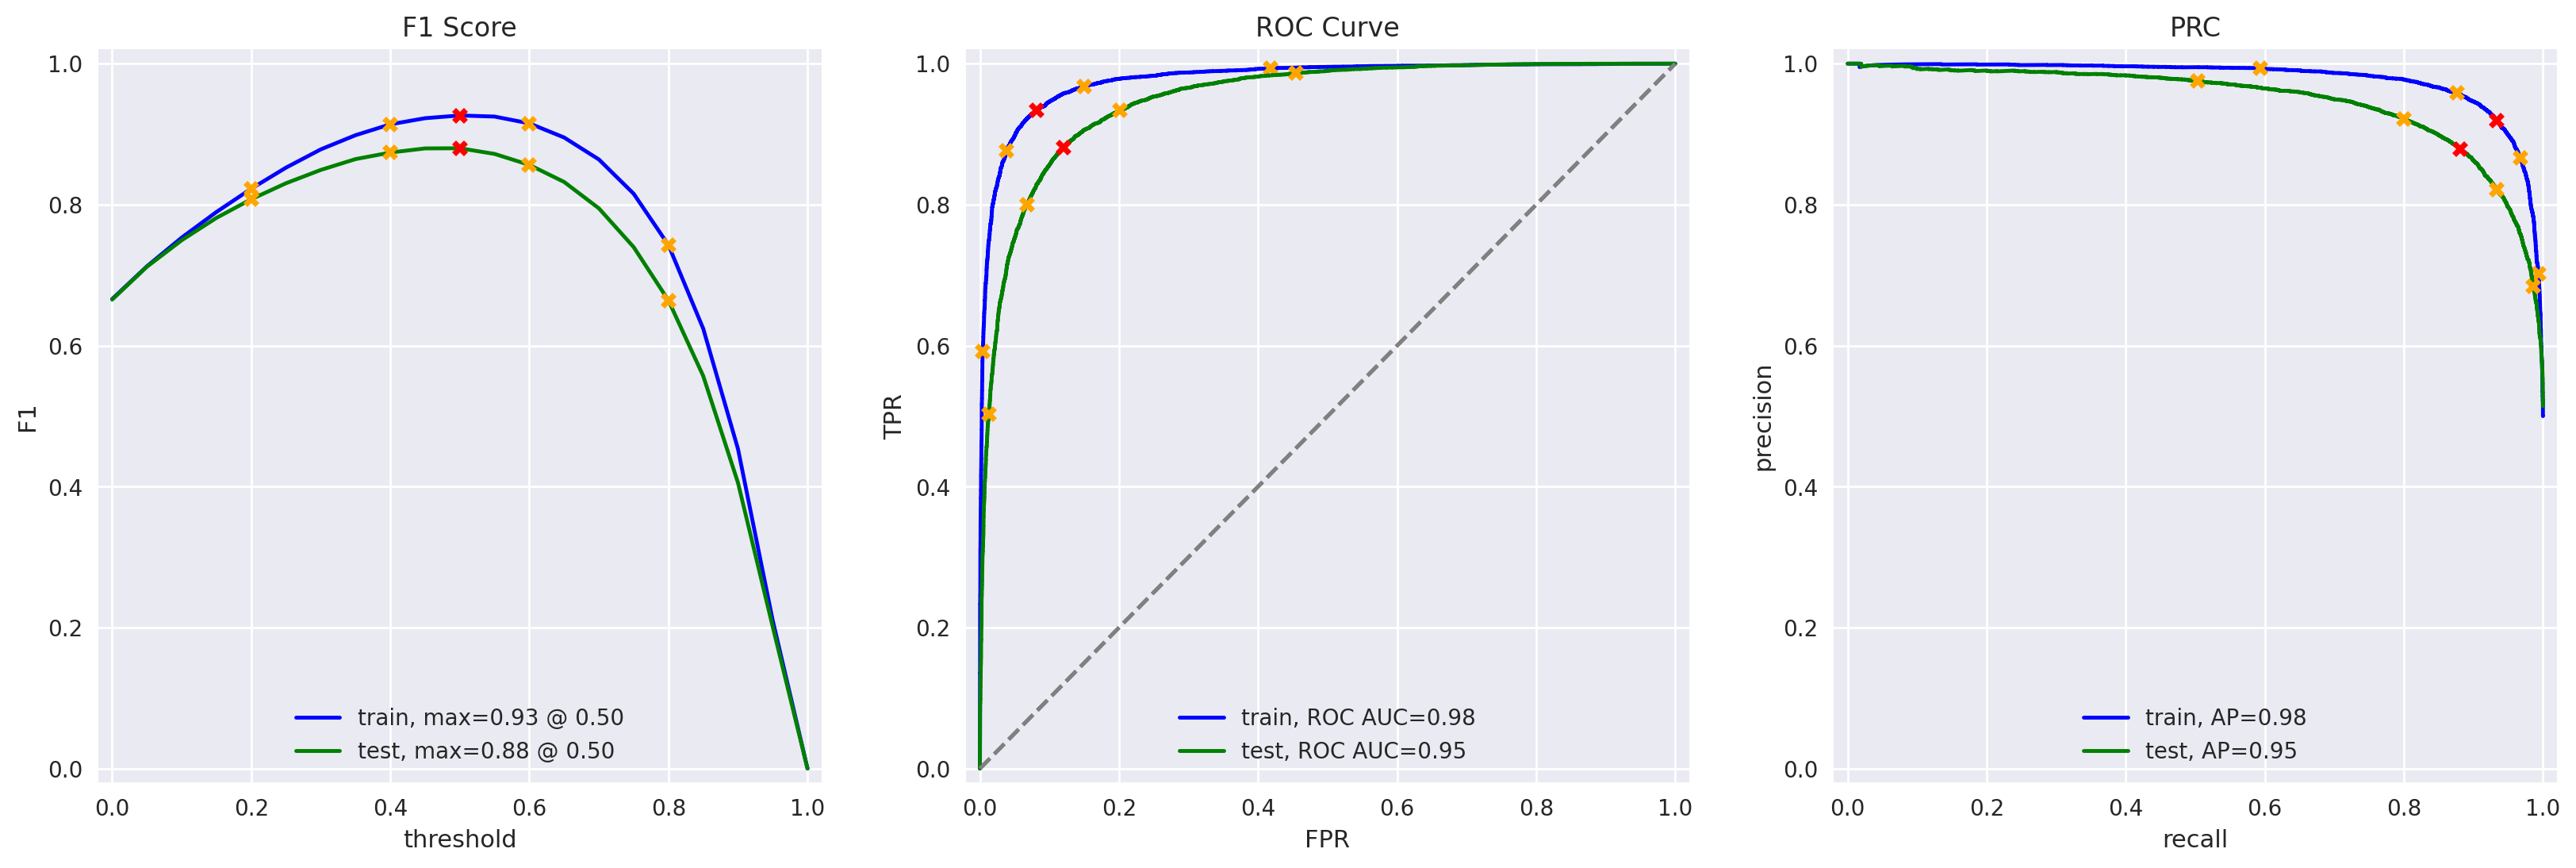

In [31]:
# Evaluate the model
evaluate_model(model_3, train_features_3, train_target, test_features_3, test_target)
plt.show()

In [32]:
# Model 0
test_preds_0 = dummy.predict(X_test_vec)
test_probs_0 = dummy.predict_proba(X_test_vec)[:, 1]

print("Model 0 results:")
print("Accuracy:", accuracy_score(test_target, test_preds_0))
print("F1:", f1_score(test_target, test_preds_0))
print("ROC AUC:", roc_auc_score(test_target, test_probs_0))
print("Average Precision (AP):", average_precision_score(test_target, test_probs_0))
print()

Model 0 results:
Accuracy: 0.5015083917569577
F1: 0.0
ROC AUC: 0.5
Average Precision (AP): 0.4984916082430423



In [33]:
# Model 1
test_preds_1 = model_1.predict(test_features_1)
test_probs_1 = model_1.predict_proba(test_features_1)[:, 1]

print("Model 1 results:")
print("Accuracy:", accuracy_score(test_target, test_preds_1))
print("F1:", f1_score(test_target, test_preds_1))
print("ROC AUC:", roc_auc_score(test_target, test_probs_1))
print("Average Precision (AP):", average_precision_score(test_target, test_probs_1))
print()

Model 1 results:
Accuracy: 0.8832377310388783
F1: 0.8828444747612552
ROC AUC: 0.9518342794204864
Average Precision (AP): 0.9495125027355764



In [34]:
# Model 3
test_preds_3 = model_3.predict(test_features_3)
test_probs_3 = model_3.predict_proba(test_features_3)[:, 1]

print("Model 3 results:")
print("Accuracy:", accuracy_score(test_target, test_preds_3))
print("F1:", f1_score(test_target, test_preds_3))
print("ROC AUC:", roc_auc_score(test_target, test_probs_3))
print("Average Precision (AP):", average_precision_score(test_target, test_probs_3))
print()

Model 3 results:
Accuracy: 0.8802209475249628
F1: 0.8799761570230341
ROC AUC: 0.9497563839181813
Average Precision (AP): 0.9480138830054514



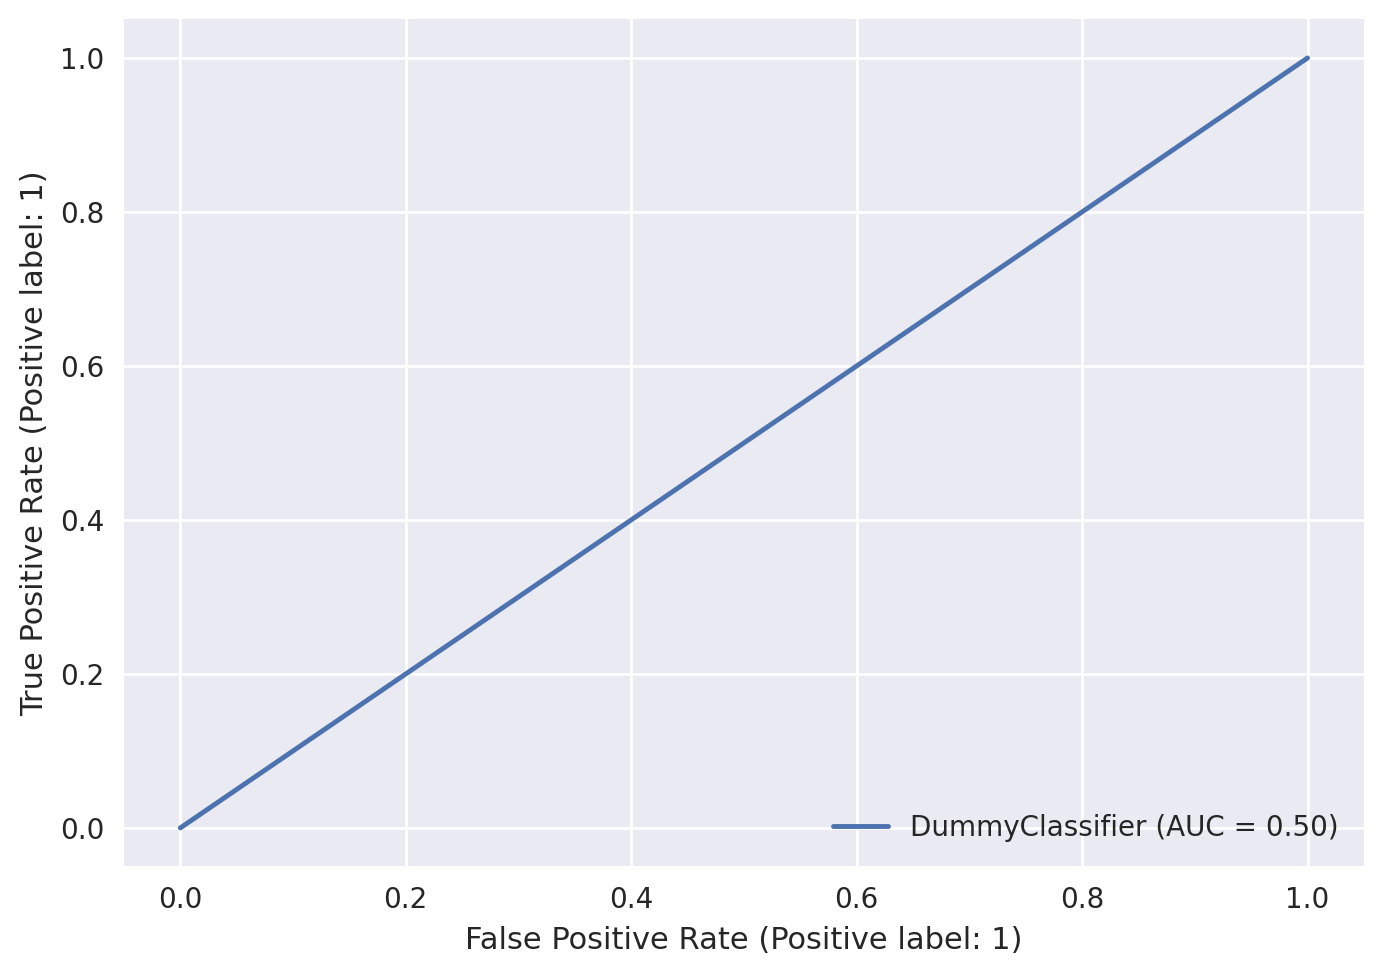

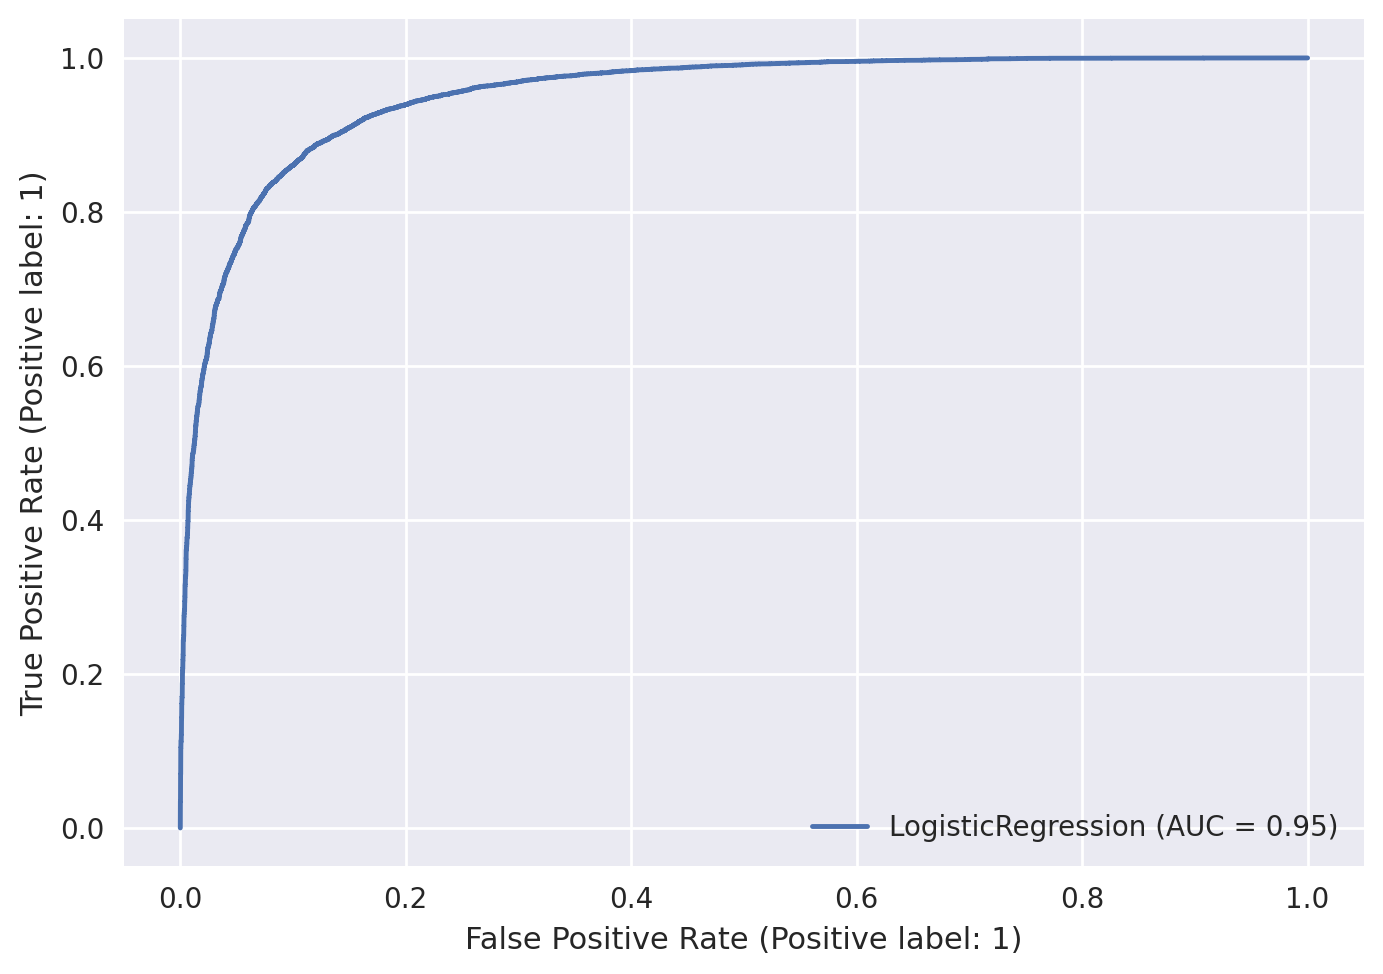

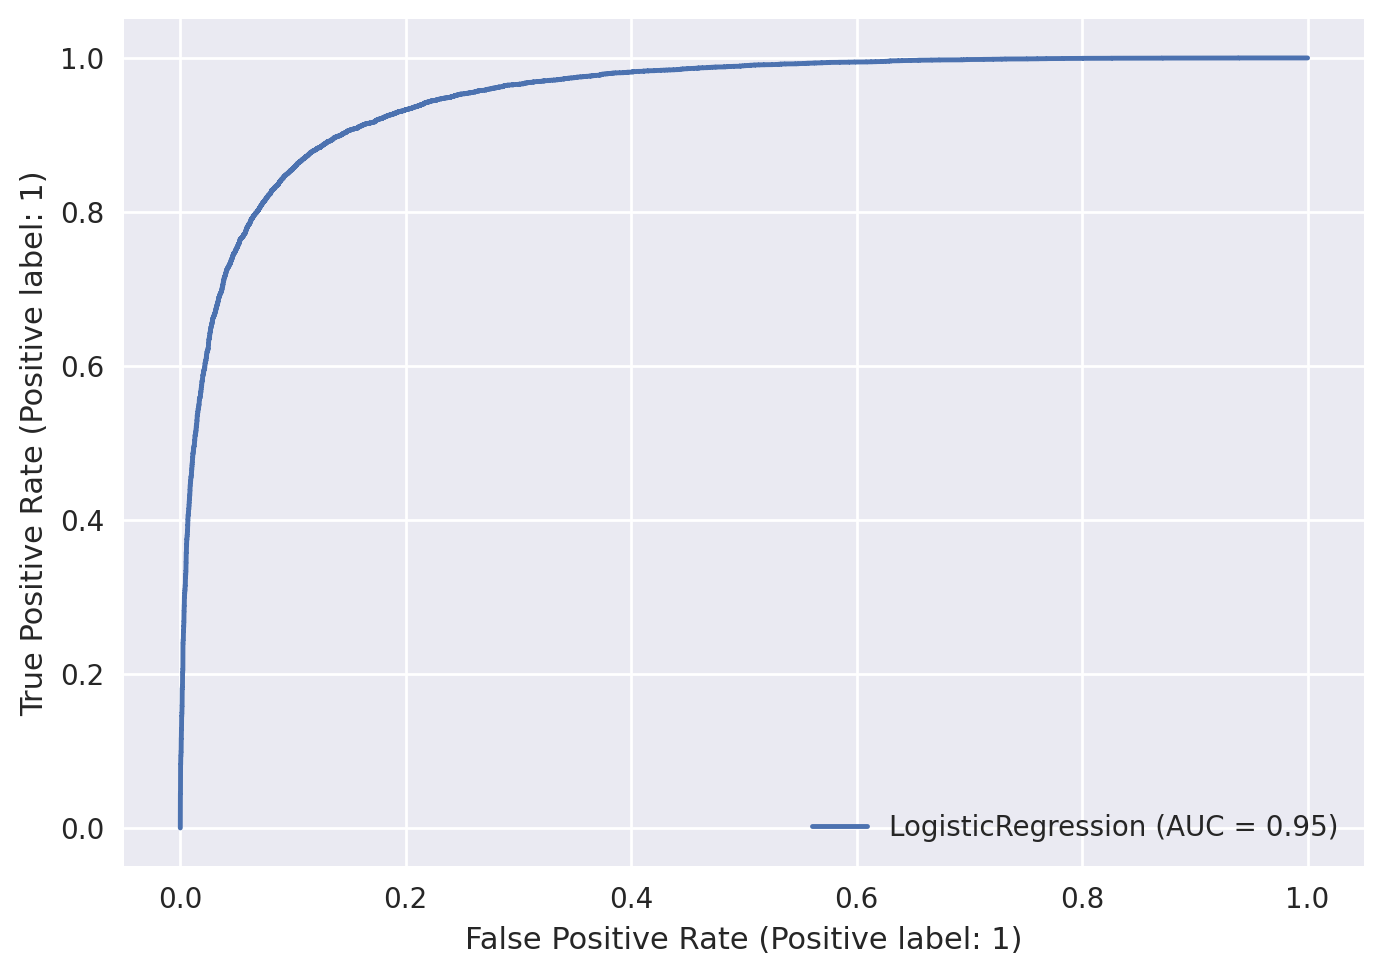

In [35]:
from sklearn.metrics import plot_roc_curve, plot_precision_recall_curve

plot_roc_curve(dummy, X_test_vec, test_target)
plot_roc_curve(model_1, test_features_1, test_target)
plot_roc_curve(model_3, test_features_3, test_target)
plt.show()

## My Reviews

In [36]:
my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

def text_preprocessing_0(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    return text

my_reviews['review_norm'] = my_reviews['review'].apply(text_preprocessing_0)

my_reviews

,review,review_norm
0,"I did not simply like it, not my kind of movie.",i did not simply like it not my kind of movie
1,"Well, I was bored and felt asleep in the middl...",well i was bored and felt asleep in the middle...
2,I was really fascinated with the movie,i was really fascinated with the movie
3,Even the actors looked really old and disinter...,even the actors looked really old and disinter...
4,I didn't expect the reboot to be so good! Writ...,i didnt expect the reboot to be so good writer...
5,"The movie had its upsides and downsides, but I...",the movie had its upsides and downsides but i ...
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy not a single...
7,Launching on Netflix was a brave move & I real...,launching on netflix was a brave move i reall...


### Model 1

In [37]:
# Create a separate vectorizer for Model 1 predictions
vectorizer_1 = TfidfVectorizer(stop_words=stopwords.words('english'))

# Fit it on the same training data that Model 1 was trained on
vectorizer_1.fit(df_reviews_train['review_norm'])

# Now transform custom reviews
texts = my_reviews['review_norm']
my_reviews_pred_prob = model_1.predict_proba(vectorizer_1.transform(texts))[:, 1]

# Print review texts with their predicted probabilities
for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}: {review}')

0.16: i did not simply like it not my kind of movie
0.18: well i was bored and felt asleep in the middle of the movie
0.56: i was really fascinated with the movie
0.13: even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.26: i didnt expect the reboot to be so good writers really cared about the source material
0.48: the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
0.05: what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.84: launching on netflix was a brave move  i really appreciate being able to binge on episode after epis


### Model 3

In [38]:
# Create a separate vectorizer for Model 3 predictions
vectorizer_3 = TfidfVectorizer()

# Fit it on the same spaCy-processed training data that Model 3 was trained on
vectorizer_3.fit(df_reviews_train['review_spacy'])

# Apply spaCy preprocessing to custom reviews
texts = my_reviews['review_norm']
texts_spacy = texts.apply(lambda x: text_preprocessing_3(x))

# Transform and predict
my_reviews_pred_prob = model_3.predict_proba(vectorizer_3.transform(texts_spacy))[:, 1]

# Print results
for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}: {review}')

0.15: i did not simply like it not my kind of movie
0.20: well i was bored and felt asleep in the middle of the movie
0.50: i was really fascinated with the movie
0.15: even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.19: i didnt expect the reboot to be so good writers really cared about the source material
0.69: the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
0.03: what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.87: launching on netflix was a brave move  i really appreciate being able to binge on episode after epis


## Conclusions

## Model Comparison and Generalization

### Performance Summary

| Model         | Accuracy (Train/Test) | F1 (Train/Test) | ROC AUC (Train/Test) | AP (Train/Test) |
|---------------|----------------------|-----------------|----------------------|-----------------|
| Dummy (0)     | 0.50 / 0.50          | 0.00 / 0.00     | 0.50 / 0.50          | 0.50 / 0.50     |
| Logistic (1)  | 0.88 / 0.88          | 0.88 / 0.88     | 0.95 / 0.95          | 0.95 / 0.95     |
| spaCy (3)     | 0.88 / 0.88          | 0.88 / 0.88     | 0.95 / 0.95          | 0.95 / 0.95     |

### Interpretation

- **Dummy Model:** Baseline performance, as expected.
- **Model 1 and Model 3:** Both achieve high accuracy and generalize well, with nearly identical train and test metrics.
- **No signs of overfitting:** Train and test performance are consistent.
- **Preprocessing and feature extraction** are likely effective and appropriate for the dataset.
- **Model 3 (spaCy)** does not outperform Model 1, suggesting either the extra preprocessing did not add significant value, or both models have reached performance limits on this dataset.
- Both Model 1 and Model 3 are strong classifiers for this problem, substantially outperforming the dummy baseline. Consistent train/test scores indicate good generalization and model robustness.

## Overall Conclusion

In this project, I explored multiple approaches to sentiment classification using text reviews, comparing a simple dummy baseline to more sophisticated logistic regression models with different preprocessing techniques. My workflow included building and evaluating:

- **Model 0:** A dummy classifier serving as a baseline for comparison.
- **Model 1:** Logistic Regression using TF-IDF features on normalized text.
- **Model 3:** Logistic Regression using TF-IDF features on spaCy-processed text.

Through systematic experimentation and evaluation, I observed the following:

- **Model Performance:** Both Model 1 and Model 3 achieved high accuracy, F1, and ROC AUC scores, substantially outperforming the dummy baseline. This demonstrates the effectiveness of machine learning models for text sentiment classification compared to naive approaches.
- **Generalization:** The models showed nearly identical performance on both training and test sets, indicating strong generalization and suggesting the absence of overfitting. THe preprocessing and feature extraction methods were consistent and appropriate for the dataset.
- **Preprocessing Impact:** While spaCy preprocessing (Model 3) did not yield a significant performance boost over simple normalization (Model 1), both models reached high levels of predictive power, suggesting that the dataset is well-suited to these methods.

**In conclusion, the project successfully demonstrates how appropriate preprocessing and the use of logistic regression models can lead to robust, generalizable, and accurate sentiment classification for text reviews. The results highlight the importance of evaluating against a baseline and using consistent train/test pipelines to validate model effectiveness.**